

## **Criação de Clusters**

Nesta seção, vamos explorar técnicas de **clustering** para segmentar os veículos do nosso dataset em grupos homogêneos. O objetivo é identificar **padrões e perfis de carros** com base em suas características, como preço, quilometragem, eficiência de combustível, tipo de tração, transmissão e outros atributos relevantes.

A análise de clusters nos permitirá:

1. **Agrupar carros com comportamentos semelhantes**, facilitando comparações e análises estratégicas.
2. **Identificar padrões ocultos** que não são facilmente percebidos com análise univariada ou bivariada.
3. **Auxiliar em tomadas de decisão**, como definição de faixas de preço, estratégias de marketing ou recomendações personalizadas para usuários.

Antes de aplicar os algoritmos de clustering, faremos o pré-processamento adequado:

* Normalização das variáveis numéricas para que todas tenham **igual importância** no cálculo das distâncias.
* Codificação das variáveis categóricas, garantindo que possam ser interpretadas pelo algoritmo.

Nesta análise, utilizaremos métodos como:

* **K-Means:** para identificar clusters baseados em distância entre os veículos.
* **Visualizações de clusters:** para entender a distribuição e características de cada grupo.

Ao final, teremos uma **segmentação clara do mercado de carros usados**, com insights que podem ser aplicados em análises de preços, perfis de clientes e recomendações de veículos.



In [52]:

#Manipulação dos dados
import pandas as pd
import numpy as np

#Visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns


#Pre processamento dos dados
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
import category_encoders as ce
from sklearn.impute import SimpleImputer

#Algorítimo a ser usado para o cluster dos clientes
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

#Metodo para avaliação do cluster
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score


#Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Para diminuir a dimensionalidade da base de dados
from sklearn.decomposition import PCA

In [53]:
train = pd.read_csv("../Dados/used_car_train.csv", index_col=0)
test = pd.read_csv("../Dados/used_car_test.csv", index_col=0)


Agora vamos tratar os dados de treino e teste para que o modelo consiga realizar a clusterização de forma adequada. Todo e qualquer tratamento realizado no conjunto de treino será replicado no conjunto de teste, garantindo que não haja data leakage.

Nesta etapa, não utilizaremos a variável price, pois os clusters serão criados apenas com base nas características dos veículos. Posteriormente, os clusters serão comparados com os preços para análise. Se incluíssemos o price neste momento, os clusters poderiam “vazar” informações sobre os preços, prejudicando a futura construção do modelo de regressão.

In [54]:
#Datasets sem o price
train_sem_price = train.drop(columns=["price"], axis=1)
test_sem_price = test.drop(columns=["price"], axis=1)

#Colunas separadas em numéricas e categóricas
colunas_numericas = train_sem_price.select_dtypes(include="number").columns
colunas_categoricas = train_sem_price.select_dtypes(include="object").columns

pipeline_variaveis_numericas = Pipeline(steps=[
    ("preencher_valores_nulos_numericos", SimpleImputer(strategy="median")),
    ("escalar_dados_numericos", RobustScaler())
])

pipeline_variaveis_categoricas = Pipeline(steps=[
    ("preencher_valores_nulos_categoricos", SimpleImputer(strategy="most_frequent")),
    ("escalar_dados_categoricos", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])


transformador_colunas = ColumnTransformer(
    transformers=[
        ("num", pipeline_variaveis_numericas, colunas_numericas),
        ("cat", pipeline_variaveis_categoricas, colunas_categoricas)
    ]
)

train_cluster = transformador_colunas.fit_transform(train_sem_price)
test_cluster = transformador_colunas.transform(test_sem_price)

In [55]:

# PCA
pca = PCA()
pca.fit(train_cluster)

# Variância explicada
explained_variance = pca.explained_variance_ratio_
explained_variance_cumulative = explained_variance.cumsum()

# Exibindo a variância explicada por cada componente
for i, (var, cum_var) in enumerate(zip(explained_variance, explained_variance_cumulative), 1):
    print(f"Componente {i}: Variância explicada = {var:.2%}, Variância acumulada = {cum_var:.2%}")

Componente 1: Variância explicada = 20.78%, Variância acumulada = 20.78%
Componente 2: Variância explicada = 14.19%, Variância acumulada = 34.97%
Componente 3: Variância explicada = 13.28%, Variância acumulada = 48.26%
Componente 4: Variância explicada = 8.65%, Variância acumulada = 56.91%
Componente 5: Variância explicada = 4.08%, Variância acumulada = 60.99%
Componente 6: Variância explicada = 3.52%, Variância acumulada = 64.51%
Componente 7: Variância explicada = 3.09%, Variância acumulada = 67.60%
Componente 8: Variância explicada = 2.63%, Variância acumulada = 70.23%
Componente 9: Variância explicada = 2.45%, Variância acumulada = 72.68%
Componente 10: Variância explicada = 2.28%, Variância acumulada = 74.96%
Componente 11: Variância explicada = 2.07%, Variância acumulada = 77.03%
Componente 12: Variância explicada = 2.05%, Variância acumulada = 79.08%
Componente 13: Variância explicada = 1.82%, Variância acumulada = 80.90%
Componente 14: Variância explicada = 1.72%, Variância acu

Irei utilizar 4 pois nos meus testes foi o valor que mais se saiu melhor

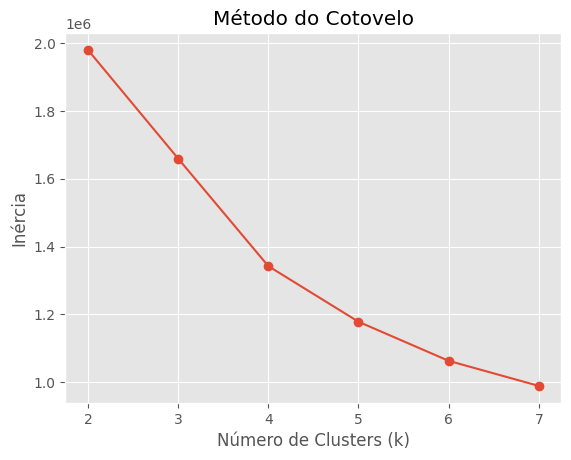

In [56]:
pca = PCA(n_components=4) 
train_pca = pca.fit_transform(train_cluster)
train_pca = pd.DataFrame(train_pca, columns=["PCA1", "PCA2", "PCA3", "PCA4"])#Base de dados que será usada para os testes de validação de cluster

inertias = []
K_range = range(2, 8)  # Testa de 1 a 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(train_pca)

    inertias.append(kmeans.inertia_)


# Plot
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()

A partir daqui, irei utilizar 4 clusters. Vale ressaltar que, para a métrica Silhouette, irei utilizar apenas 10% dos dados. Como essa métrica calcula a distância entre todos os pontos, usar a base completa seria inviável devido ao tempo de processamento, tornando a execução extremamente lenta.

In [57]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels_Kmean = kmeans.fit_predict(train_pca)

score = calinski_harabasz_score(train_pca, labels_Kmean)
print("Calinski-Harabasz:", score)

score = davies_bouldin_score(train_pca, labels_Kmean)
print("Davies-Bouldin:", score)



# Silhouette aproximado usando 10% dos dados
score = silhouette_score(train_pca, labels_Kmean, metric='euclidean', sample_size=int(0.1*len(train_pca)), random_state=42)
print("Silhouette (amostrado 10%):", score)


Calinski-Harabasz: 148358.51683796628
Davies-Bouldin: 1.112737136850437
Silhouette (amostrado 10%): 0.3257136382067581




Os resultados com o KMeans foram satisfatórios, considerando o tamanho da base de dados. Agora, irei analisar o desempenho do **DBSCAN**, comparando a distribuição dos clusters e métricas como Calinski-Harabasz, Davies-Bouldin e Silhouette para verificar se ele consegue capturar estruturas diferentes nos dados.


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
import numpy as np

# Amostra de 10% da base
np.random.seed(42)
amostra_indices = np.random.choice(len(train_pca), size=int(0.1*len(train_pca)), replace=False)
train_pca_amostra= train_pca.iloc[amostra_indices]

eps_valores = np.arange(0.1, 1.0, 0.1)
min_amostra_values = range(2, 10)

best_score_c = -1
best_score_d = np.inf
best_params = {}

for eps in eps_valores:
    for min_amostras in min_amostra_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_amostras, algorithm='kd_tree', metric='euclidean')
        labels = dbscan.fit_predict(train_pca_amostra)
        
        # Ignora caso todos os pontos estejam em um único cluster ou sejam ruído
        if len(set(labels)) <= 1:
            continue
        
        scoreC = calinski_harabasz_score(train_pca_amostra, labels)
        scoreD = davies_bouldin_score(train_pca_amostra, labels)
        print(f"eps: {eps}, min_samples: {min_amostras}, Calinski-Harabasz: {scoreC:.2f}, Davies-Bouldin: {scoreD:.2f}")
        
        # Atualiza melhor combinação (Calinski-Harabasz maior e Davies-Bouldin menor)
        if scoreC > best_score_c and scoreD < best_score_d:
            best_score_c = scoreC
            best_score_d = scoreD
            best_params = {"eps": eps, "min_samples": min_amostras}

print("\nMelhor Parâmetros:", best_params)
print(f"Melhor Calinski-Harabasz: {best_score_c:.2f}")
print(f"Melhor Davies-Bouldin: {best_score_d:.2f}")


eps: 0.1, min_samples: 2, Calinski-Harabasz: 29.55, Davies-Bouldin: 1.43
eps: 0.1, min_samples: 3, Calinski-Harabasz: 37.20, Davies-Bouldin: 1.40
eps: 0.1, min_samples: 4, Calinski-Harabasz: 42.44, Davies-Bouldin: 1.35
eps: 0.1, min_samples: 5, Calinski-Harabasz: 44.84, Davies-Bouldin: 1.34
eps: 0.1, min_samples: 6, Calinski-Harabasz: 45.75, Davies-Bouldin: 1.34
eps: 0.1, min_samples: 7, Calinski-Harabasz: 48.13, Davies-Bouldin: 1.33
eps: 0.1, min_samples: 8, Calinski-Harabasz: 48.62, Davies-Bouldin: 1.30
eps: 0.1, min_samples: 9, Calinski-Harabasz: 47.61, Davies-Bouldin: 1.31
eps: 0.2, min_samples: 2, Calinski-Harabasz: 82.64, Davies-Bouldin: 1.42
eps: 0.2, min_samples: 3, Calinski-Harabasz: 114.03, Davies-Bouldin: 1.39
eps: 0.2, min_samples: 4, Calinski-Harabasz: 137.55, Davies-Bouldin: 1.37
eps: 0.2, min_samples: 5, Calinski-Harabasz: 148.00, Davies-Bouldin: 1.38
eps: 0.2, min_samples: 6, Calinski-Harabasz: 150.96, Davies-Bouldin: 1.35
eps: 0.2, min_samples: 7, Calinski-Harabasz: 16

In [ ]:
dbscan = DBSCAN(eps=0.9, min_samples=9, algorithm='kd_tree', metric='euclidean')
labels = dbscan.fit_predict(train_pca_amostra)

# Silhouette aproximado usando 10% dos dados
score = silhouette_score(train_pca_amostra, labels, metric='euclidean', random_state=42)
print("Silhouette (amostrado 10%):", score)

Silhouette (amostrado 10%): 0.29311988863225


Um resultado menor que o kmeans, logo, para finalizar irei analisar o ultimo modelo que é o GaussianMixture.

k	AIC		BIC		Silhouette
--------------------------------------------
2	5479321.7	5479643.8	0.2570
3	5176473.3	5176961.8	0.1815
4	5021121.6	5021776.7	0.1793
5	4919031.0	4919852.7	0.1601
6	4861479.7	4862468.0	0.1201
7	4843067.0	4844221.7	0.1466


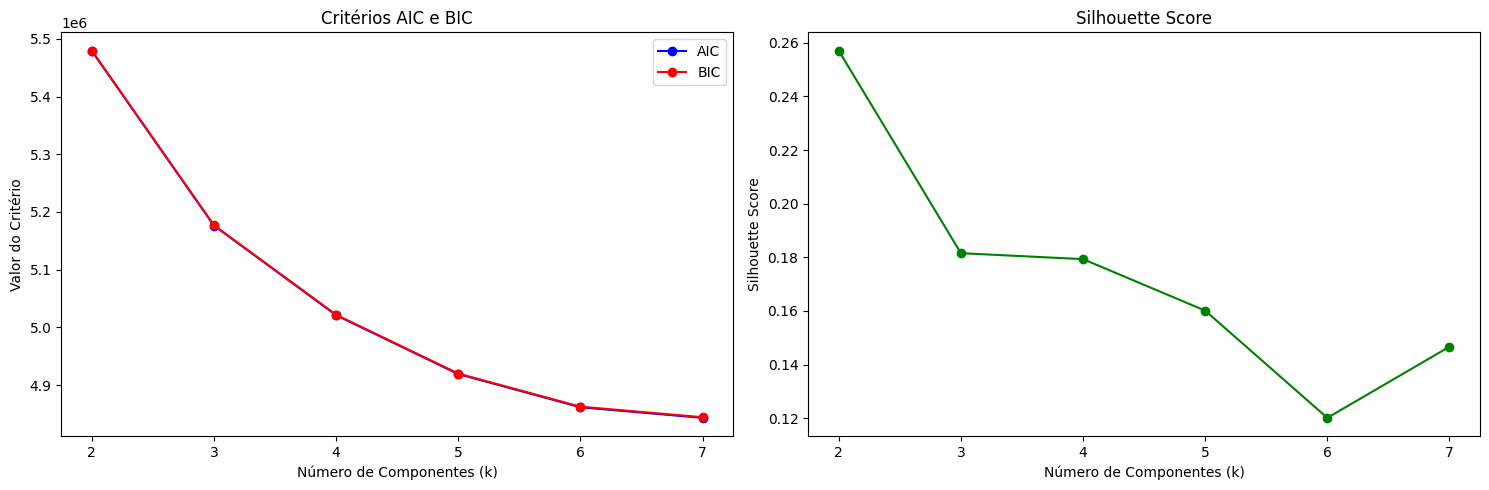

In [ ]:
# Listas para armazenar as métricas
aics = []
bics = []
silhouettes = []
K_range = range(2, 8)  # Testando de 2 a 10 componentes

print("k\tAIC\t\tBIC\t\tSilhouette")
print("--------------------------------------------")

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(train_pca)
    labels = gmm.predict(train_pca)
    
    # Calculando as métricas
    aic = gmm.aic(train_pca)
    bic = gmm.bic(train_pca)
    silhouette = silhouette_score(train_pca, labels,  sample_size=int(0.1*len(train_pca)), random_state=42)
    
    # Armazenando os valores
    aics.append(aic)
    bics.append(bic)
    silhouettes.append(silhouette)
    
    print(f"{k}\t{aic:.1f}\t{bic:.1f}\t{silhouette:.4f}")

# Plotando os gráficos
plt.figure(figsize=(15, 5))

# Gráfico AIC e BIC
plt.subplot(1, 2, 1)
plt.plot(K_range, aics, 'bo-', label='AIC')
plt.plot(K_range, bics, 'ro-', label='BIC')
plt.xlabel('Número de Componentes (k)')
plt.ylabel('Valor do Critério')
plt.title('Critérios AIC e BIC')
plt.legend()
plt.xticks(K_range)

# Gráfico Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouettes, 'go-')
plt.xlabel('Número de Componentes (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.xticks(K_range)

plt.tight_layout()
plt.show()

Os resultados do GaussianMixture também foram um pouco piores que o do Kmeans, logo ele vai ser o modelo para ser utilizado até o final. Agora vamos gerar os labels e fazer nossas analises! Primeiro vamos analisar se a distribuição das labels do kmeans.

In [58]:
# Contagem de pontos por cluster
def conta_quant_labels(labels_kmeans):
    unique_labels, counts = np.unique(labels_kmeans, return_counts=True)

    print("Distribuição dos clusters:")
    for label, count in zip(unique_labels, counts):
        if label == -1:
            print(f"  Ruído (label -1): {count} pontos")
        else:
            print(f"  Cluster {label}: {count} pontos")
conta_quant_labels(labels_Kmean)

Distribuição dos clusters:
  Cluster 0: 274867 pontos
  Cluster 1: 77134 pontos
  Cluster 2: 47063 pontos
  Cluster 3: 91666 pontos


Analisando os clusters acima estão bem distribuidos, agora irei adiciona-los no dataset de treino e começar a análise! Mas antes irei tambem adicionar os labels no dataset de teste.

In [59]:
teste_pca = pca.transform(test_cluster)
teste_pca = pd.DataFrame(teste_pca, columns=["PCA1", "PCA2", "PCA3", "PCA4"])
labels_Kmean_test = kmeans.predict(teste_pca)
conta_quant_labels(labels_Kmean_test)

Distribuição dos clusters:
  Cluster 0: 86525 pontos
  Cluster 1: 19206 pontos
  Cluster 2: 17232 pontos
  Cluster 3: 27627 pontos


Agora com as labels de teste e de treino é só acrescentar nos dados originais e começar as analises

In [60]:
train["cluster"] = labels_Kmean.ravel()
test["cluster"] = labels_Kmean_test.ravel()

train.head()

,manufacturer,year,mileage,mpg,accidents_or_damage,one_owner,personal_use_only,driver_rating,driver_reviews_num,price,transmission_simple,color_exterior_simple,color_interior_simple,drivetrain_simple,fuel_type_simple,cluster
561046,Nissan,2022,7963.0,19.5,0.0,1.0,1.0,4.2,19.0,35693.0,Automatic,red,black,4WD,Gasoline,2
390497,Jeep,2017,65998.0,21.5,0.0,0.0,1.0,4.8,335.0,22999.0,Automatic,white,black,4WD,Gasoline,1
13707,Other,2017,50986.0,29.0,0.0,0.0,1.0,4.8,90.0,23900.0,Manual,black,black,FWD,Gasoline,0
576420,Nissan,2018,74244.0,28.5,0.0,0.0,0.0,4.7,417.0,18988.0,Automatic,black,black,AWD,Gasoline,1
247684,Ford,2021,18908.0,23.5,0.0,0.0,0.0,4.8,31.0,34189.0,Automatic,gray,black,RWD,Gasoline,0


In [61]:
train["cluster"] = train["cluster"].astype("object")
test["cluster"] = test["cluster"].astype("object")

## Análise dos clusters

### **Variaveis Numéricas**

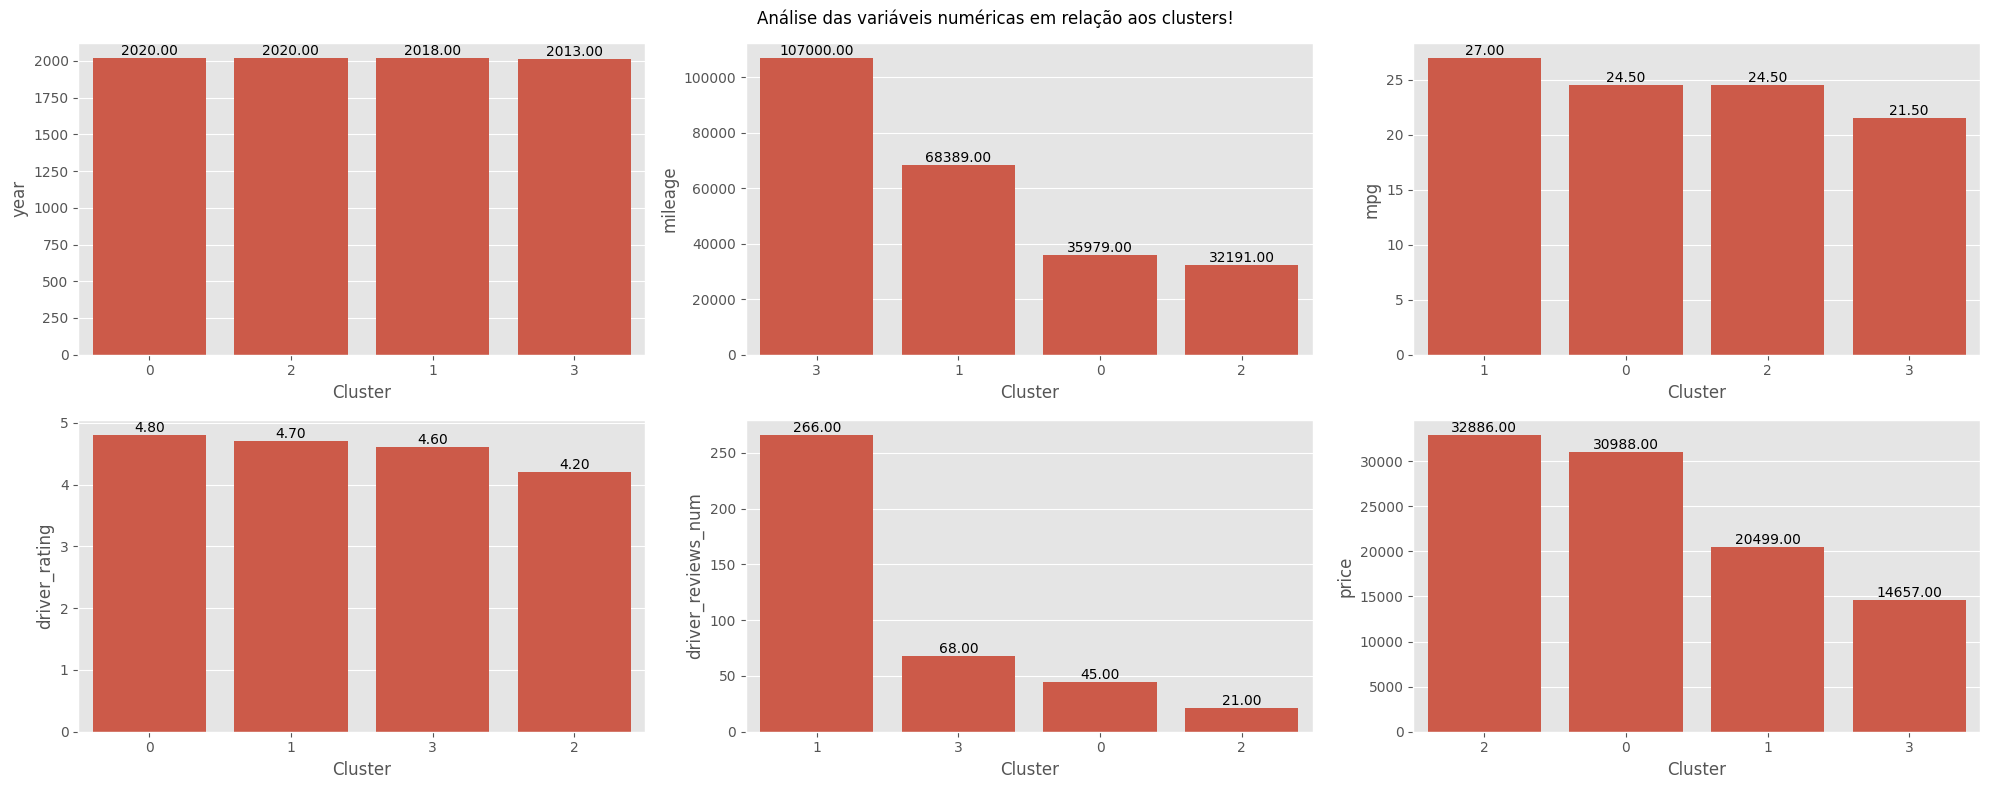

In [36]:
colunas_numericas = ['year', 'mileage', 'mpg', 'driver_rating', 'driver_reviews_num', 'price']

plt.style.use("ggplot")
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))
axes = axes.flatten()
plt.suptitle("Análise das variáveis numéricas em relação aos clusters!")

for i, col in enumerate(colunas_numericas):
    
    cluster_analise = train[["cluster", col]].groupby("cluster").median().reset_index().sort_values(by=col, ascending=False)
    
    cluster_analise.columns = ["Cluster", "Valores"]
    ordem_clusters = cluster_analise["Cluster"].tolist()
    sns.barplot(data=cluster_analise, x="Cluster", y="Valores", ax=axes[i], order=ordem_clusters)
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel(col)

    for j, v in enumerate(cluster_analise["Valores"]):
        
        axes[i].text(j, v, f"{v:.2f}", ha="center", va="bottom")


plt.tight_layout()
plt.show()


### Análise dos Clusters

Com base nas variáveis **`year`, `mileage`, `mpg`, `driver_rating`, `driver_reviews_num` e `price`**, foram obtidos os seguintes insights:

* **Cluster 0**: Carros mais **recentes**, com **baixa quilometragem**, **mpg moderado**, **melhor avaliação** entre os clusters, poucas reviews e **preço elevado** (provavelmente devido à combinação de ano recente e baixa quilometragem).

* **Cluster 1**: Carros também **recentes**, com a **segunda maior quilometragem** (ainda relativamente baixa), **maior mpg**, boa avaliação, **maior quantidade de reviews** e **segundo preço mais baixo**.

* **Cluster 2**: Carros **recentes**, com **quilometragem muito baixa**, **mpg semelhante ao cluster 0**, rating bom mas o **mais baixo de todos (≈4.2)**, poucas reviews, porém **os mais caros** (reforçando a relação de ano recente + baixa quilometragem + poucas reviews como indicativos de preços altos).

* **Cluster 3**: Carros **mais antigos**, com **maior quilometragem**, **menor mpg**, rating ainda bom, **segundo maior em número de reviews**, e os **carros mais baratos** entre os clusters.


Esses resultados mostram que o **ano do veículo** e a **quilometragem** são fatores decisivos para a precificação, enquanto a **quantidade de reviews** e a **avaliação do motorista** podem influenciar a percepção de valor pelo consumidor. Carros **recentes com baixa quilometragem** (clusters 0 e 2) são consistentemente os mais caros, mesmo quando apresentam poucas avaliações. Já os **carros mais antigos e com maior uso** (cluster 3) formam o segmento mais acessível, atraindo provavelmente consumidores mais sensíveis a preço. O cluster 1, por outro lado, representa um perfil equilibrado, com carros recentes, bom desempenho em mpg, muitas avaliações e preço competitivo — o que pode indicar uma boa **oportunidade de marketing** voltada a clientes que buscam custo-benefício.



### **Variaveis Binárias**

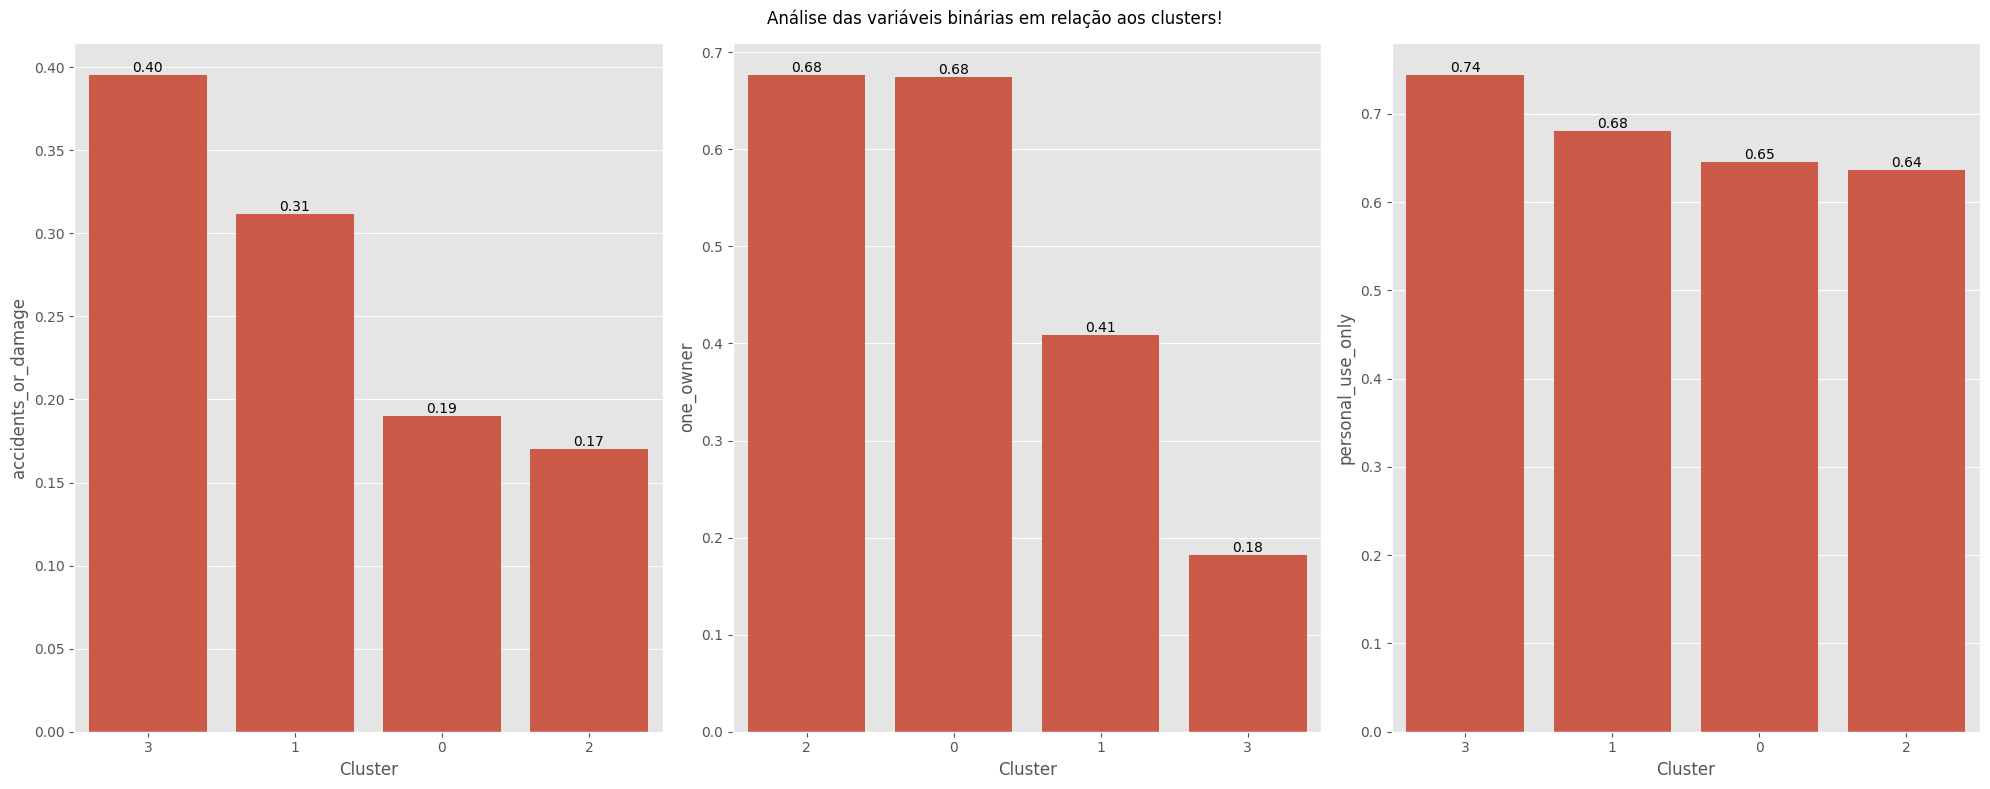

In [41]:
colunas_binarias = ['accidents_or_damage', 'one_owner','personal_use_only']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
axes = axes.flatten()
plt.suptitle("Análise das variáveis binárias em relação aos clusters!")

for i, col in enumerate(colunas_binarias):
    
    cluster_analise = train[["cluster", col]].groupby("cluster").mean().reset_index().sort_values(by=col, ascending=False)
    
    cluster_analise.columns = ["Cluster", "Valores"]

    ordem_clusters = cluster_analise["Cluster"].tolist()
    sns.barplot(data=cluster_analise, x="Cluster", y="Valores", ax=axes[i], order=ordem_clusters)
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel(col)

    for j, v in enumerate(cluster_analise["Valores"]):
        
        axes[i].text(j, v, f"{v:.2f}", ha="center", va="bottom")


plt.tight_layout()
plt.show()




**Análise das variáveis binárias (`accidents_or_damage`, `one_owner`, `personal_use_only`) em relação aos clusters:**

* **Cluster 0:** apresenta **baixa taxa de acidentes ou danos**, o que ajuda a explicar os preços elevados identificados anteriormente, já que veículos com histórico mais limpo tendem a valer mais. Além disso, a maioria teve apenas **um dono**, característica que na EDA mostrou relação com preços maiores. O uso pessoal, entretanto, aparece em proporção mais baixa.

* **Cluster 1:** possui uma **taxa mais alta de acidentes ou danos** (média em torno de 31%). A maioria dos carros não teve apenas um dono, mas destaca-se pela **alta proporção de uso pessoal** (cerca de 68%). Esse perfil reforça a ideia de veículos mais acessíveis e voltados ao dia a dia.

* **Cluster 2:** é o grupo com **menor incidência de acidentes/danos**. Além disso, a maioria dos carros **teve apenas um dono**, e são os que apresentam a **menor taxa de uso pessoal**. Esse perfil reforça um posicionamento de maior valorização de mercado, alinhado aos preços altos observados nesse cluster.

* **Cluster 3:** concentra os veículos com **maior ocorrência de acidentes/danos**. Também é o grupo com **menos casos de carros de único dono**, o que ajuda a justificar os preços mais baixos, já que múltiplos donos geralmente reduzem o valor de revenda. Além disso, a proporção de **uso pessoal é bastante elevada**, reforçando o perfil de veículos mais populares e baratos.



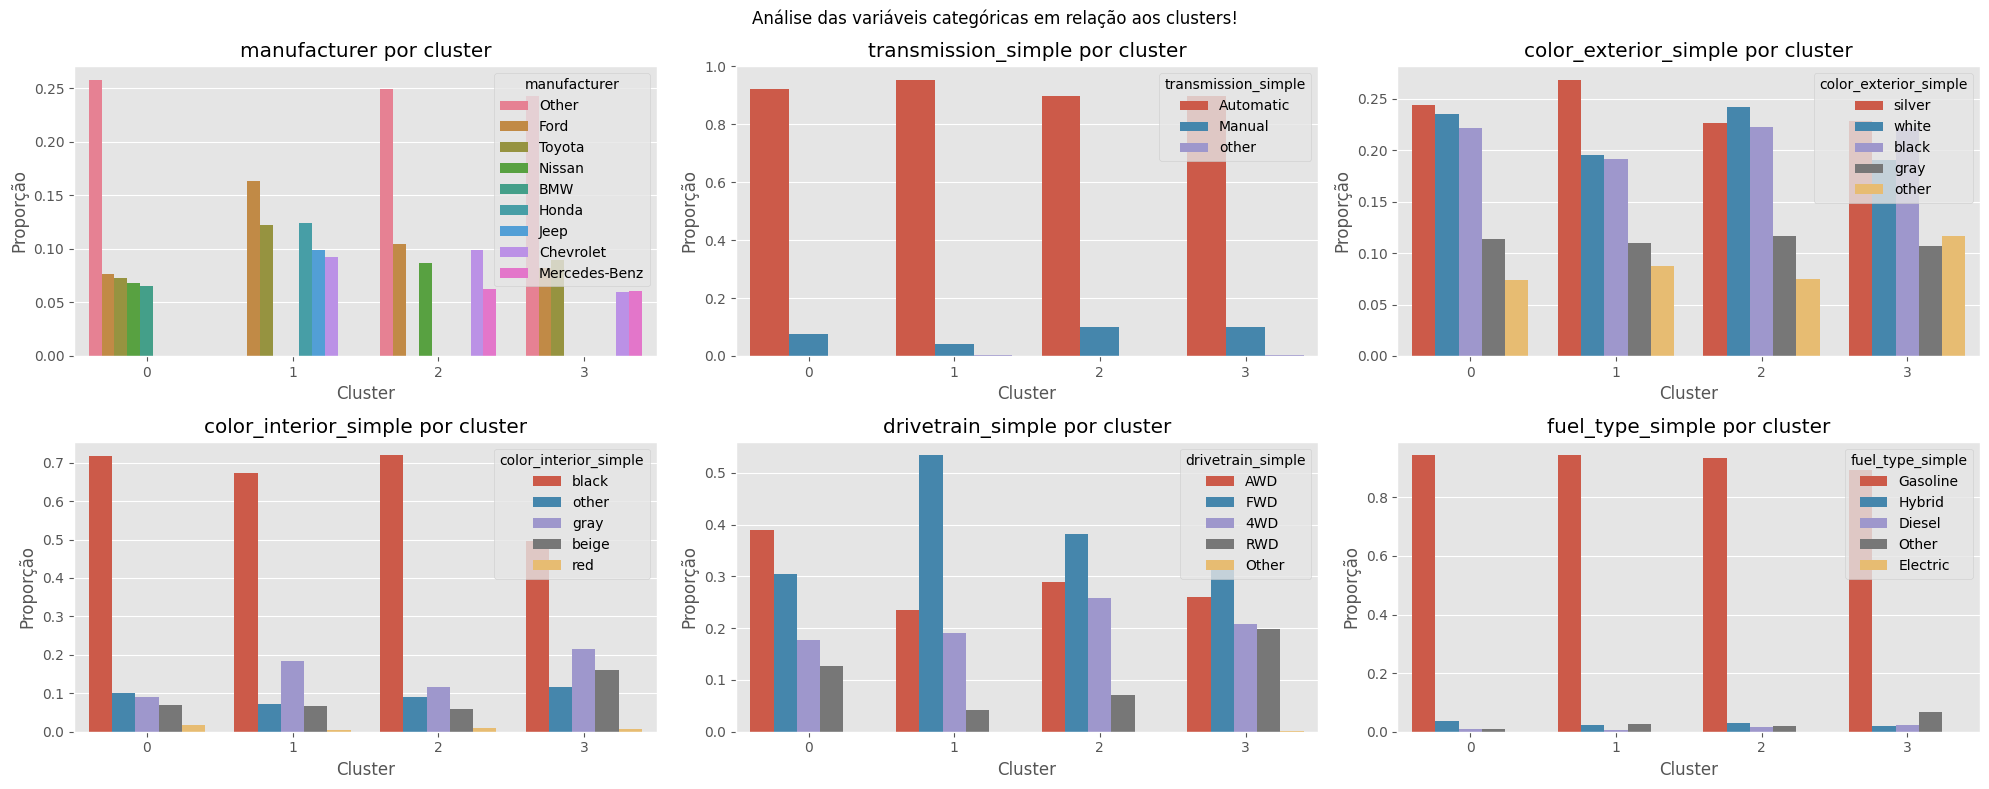

In [ ]:
colunas_categoricas = train.select_dtypes(include="object").drop(columns="cluster", axis=1).columns

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))
axes = axes.flatten()
plt.suptitle("Análise das variáveis categóricas em relação aos clusters!")

for i, col in enumerate(colunas_categoricas):
    # calcular proporções por cluster
    cluster_analise = (
        train.groupby("cluster")[col]
        .value_counts(normalize=True)  # proporção
        .rename("Proporcao")
        .reset_index()
        .sort_values(by="Proporcao", ascending=False)
    )

    # pegar as categorias mais frequentes por cluster (pode ajustar se quiser ver todas)
    top_cat = cluster_analise.groupby("cluster").head(5)

    sns.barplot(
        data=top_cat,
        x="cluster",
        y="Proporcao",
        hue=col,  # aqui vai separar pelas categorias
        ax=axes[i]
    )

    axes[i].set_title(f"{col} por cluster")
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel("Proporção")

plt.tight_layout()
plt.show()




**Análise das variáveis categóricas em relação aos clusters:**

**Padrão geral:**

* A grande maioria dos carros possui **transmissão automática** (automatic transmission).
* A cor do **interior** é predominantemente **preta** (black).
* O tipo de combustível mais comum é **gasolina** (gasoline).
* Quanto ao fabricante (manufacturer), a maior parte dos veículos está categorizada como **"outros"** (others).

**Cluster 0:**

* Carros mais presentes da categoria **"outros"**, seguidos pelos **Ford**.
* As cores externas (exterior color) estão bem distribuídas, mas com uma leve predominância para **prata** (silver).
* O **sistema de tração** (drivetrain) mais usado é **AWD** (All Wheel Drive – tração nas quatro rodas).

**Cluster 1:**

* Uma boa parcela de carros são **Ford**.
* A cor externa mais comum é **prata** (silver).
* O **sistema de tração** predominante é **FWD** (Front Wheel Drive – tração dianteira).

**Cluster 2:**

* Carros majoritariamente da categoria **"outros"**, seguidos pelos **Ford**.
* A cor externa mais frequente é **branca** (white).
* O **sistema de tração** mais utilizado é **FWD** (tração dianteira).

**Cluster 3:**

* A cor externa predominante é **prata** (silver).
* O **sistema de tração** predominante é **FWD** (tração dianteira).

Feito isso irei salvar os dados com seus devidos clusters e dar um overall dos clusters e em que categorias eles serão usados

---

### Overview Geral dos Clusters

Com base nas análises quantitativas e qualitativas, podemos caracterizar os quatro clusters da seguinte forma:

| Cluster | Quantidade de veículos | Nome sugerido               | Características principais                                                                                                                                                                                                                                                                              |
| ------- | ---------------------- | --------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 0       | 274.867                | **Carros Premium**          | Veículos mais recentes, baixa quilometragem, mpg moderado, melhor avaliação, poucas reviews, preço elevado. Baixa taxa de acidentes ou danos, maioria com apenas um dono, uso pessoal menos frequente. Drivetrain AWD predominante, cores externas variadas (predomínio de prata).                      |
| 1       | 77.134                 | **Carros Custo-Benefício**  | Carros recentes, segunda maior quilometragem, maior mpg, boa avaliação, maior número de reviews, preço competitivo. Maior taxa de acidentes ou danos, uso pessoal frequente. Predominantemente Ford, cor externa prata, drivetrain FWD.                                                                 |
| 2       | 47.063                 | **Carros Luxo/Valorizados** | Veículos recentes, quilometragem muito baixa, mpg similar ao cluster 0, avaliação boa (mas menor que o cluster 0), poucas reviews, os mais caros. Baixa incidência de acidentes/danos, maioria com um dono, uso pessoal baixo. Categoria "outros" predominante, drivetrain FWD, cores externas brancas. |
| 3       | 91.666                 | **Carros Populares/Usados** | Veículos mais antigos, maior quilometragem, menor mpg, avaliação boa, segundo maior número de reviews, preço mais baixo. Maior ocorrência de acidentes/danos, menor proporção de carros de único dono, alto uso pessoal. Cor externa prata, drivetrain FWD.                                             |

---

### Recomendações e Insights Estratégicos

1. **Fatores de precificação**:

   * O **ano do veículo** e a **quilometragem** são decisivos para o preço.
   * **Acidentes/danos** e **número de proprietários anteriores** influenciam o valor percebido.
   * Clusters com veículos recentes e baixa quilometragem (clusters 0 e 2) apresentam consistentemente preços elevados.

2. **Perfil do cliente por cluster**:

   * **Cluster 0 (Carros Premium)**: clientes que buscam desempenho e status; alto poder aquisitivo.
   * **Cluster 1 (Custo-Benefício)**: consumidores focados em economia e confiabilidade; valorizam boas reviews e mpg.
   * **Cluster 2 (Carros Luxo/Valorizados)**: nicho de mercado com valorização de exclusividade e estado do veículo; preços altos justificados pela raridade.
   * **Cluster 3 (Carros Populares/Usados)**: compradores sensíveis ao preço; priorizam custo acessível e uso prático.

3. **Considerações para o modelo de regressão**:

   * Usar o **cluster como variável categórica** pode capturar padrões de precificação não lineares.
   * A inclusão das variáveis de **uso, histórico de acidentes e número de proprietários** é recomendada, pois impactam diretamente o valor do veículo.
   * O modelo pode ser ajustado por cluster, ou utilizar interações entre cluster e outras variáveis (ex: cluster × quilometragem) para melhorar a acurácia.



In [62]:
nomes_clusters = {
    0: "Carros Premium",
    1: "Carros Custo-Benefício",
    2: "Carros Luxos/Valorizados",
    3: "Carros Populares/Usados"
}

train["cluster"] = train["cluster"].map(nomes_clusters)
test["cluster"] = test["cluster"].map(nomes_clusters)

In [64]:
train.head()

,manufacturer,year,mileage,mpg,accidents_or_damage,one_owner,personal_use_only,driver_rating,driver_reviews_num,price,transmission_simple,color_exterior_simple,color_interior_simple,drivetrain_simple,fuel_type_simple,cluster
561046,Nissan,2022,7963.0,19.5,0.0,1.0,1.0,4.2,19.0,35693.0,Automatic,red,black,4WD,Gasoline,Carros Luxos/Valorizados
390497,Jeep,2017,65998.0,21.5,0.0,0.0,1.0,4.8,335.0,22999.0,Automatic,white,black,4WD,Gasoline,Carros Custo-Benefício
13707,Other,2017,50986.0,29.0,0.0,0.0,1.0,4.8,90.0,23900.0,Manual,black,black,FWD,Gasoline,Carros Premium
576420,Nissan,2018,74244.0,28.5,0.0,0.0,0.0,4.7,417.0,18988.0,Automatic,black,black,AWD,Gasoline,Carros Custo-Benefício
247684,Ford,2021,18908.0,23.5,0.0,0.0,0.0,4.8,31.0,34189.0,Automatic,gray,black,RWD,Gasoline,Carros Premium


Após a substituição irei salvar os dados para ir para a fazer do modelo de regressão.

In [65]:
train.to_csv("../Dados/used_car_train.csv")
test.to_csv("../Dados/used_car_test.csv")